training.csv found. Loading...

Starting 5-Fold Cross Validation with Visualization...

===== FOLD 1/5 =====
[0]	validation_0-auc:0.89158	validation_0-logloss:0.62054	validation_1-auc:0.88199	validation_1-logloss:0.62121
[100]	validation_0-auc:0.93412	validation_0-logloss:0.31583	validation_1-auc:0.90916	validation_1-logloss:0.35797
[200]	validation_0-auc:0.94653	validation_0-logloss:0.28720	validation_1-auc:0.91053	validation_1-logloss:0.35436
[300]	validation_0-auc:0.95678	validation_0-logloss:0.26469	validation_1-auc:0.91048	validation_1-logloss:0.35454
[301]	validation_0-auc:0.95687	validation_0-logloss:0.26448	validation_1-auc:0.91047	validation_1-logloss:0.35457
Fold 1 Best AMS: 3.7394

===== FOLD 2/5 =====
[0]	validation_0-auc:0.85136	validation_0-logloss:0.62547	validation_1-auc:0.84115	validation_1-logloss:0.62597
[100]	validation_0-auc:0.93399	validation_0-logloss:0.31594	validation_1-auc:0.91078	validation_1-logloss:0.35573
[200]	validation_0-auc:0.94687	validation_0-logloss

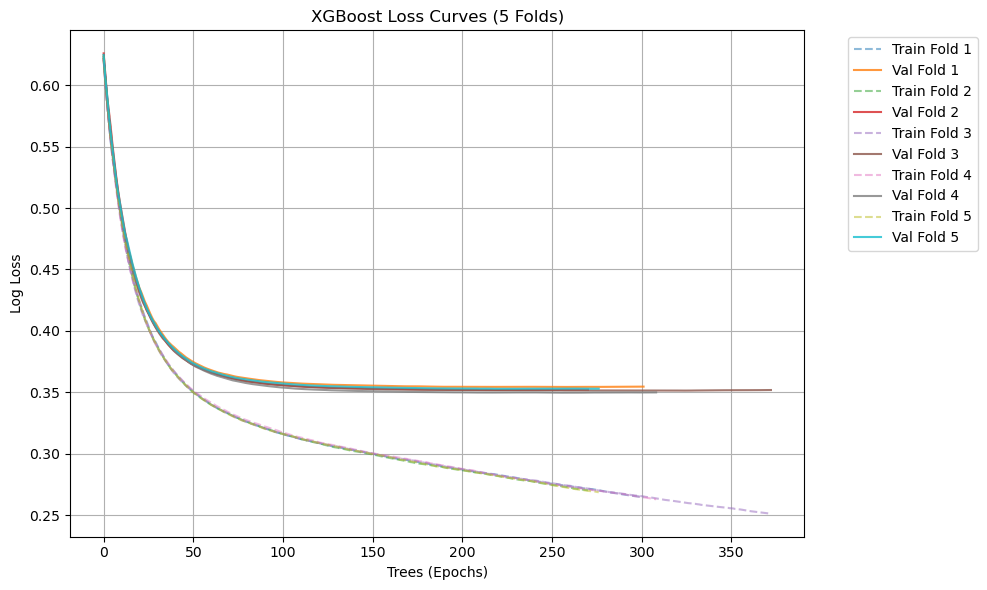

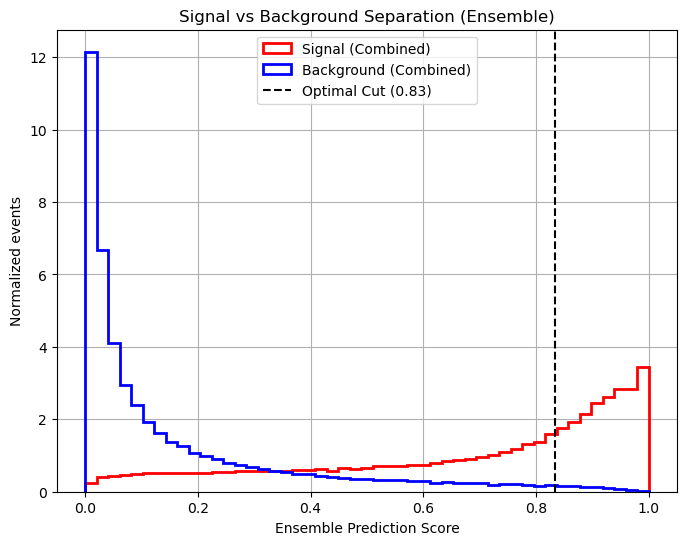

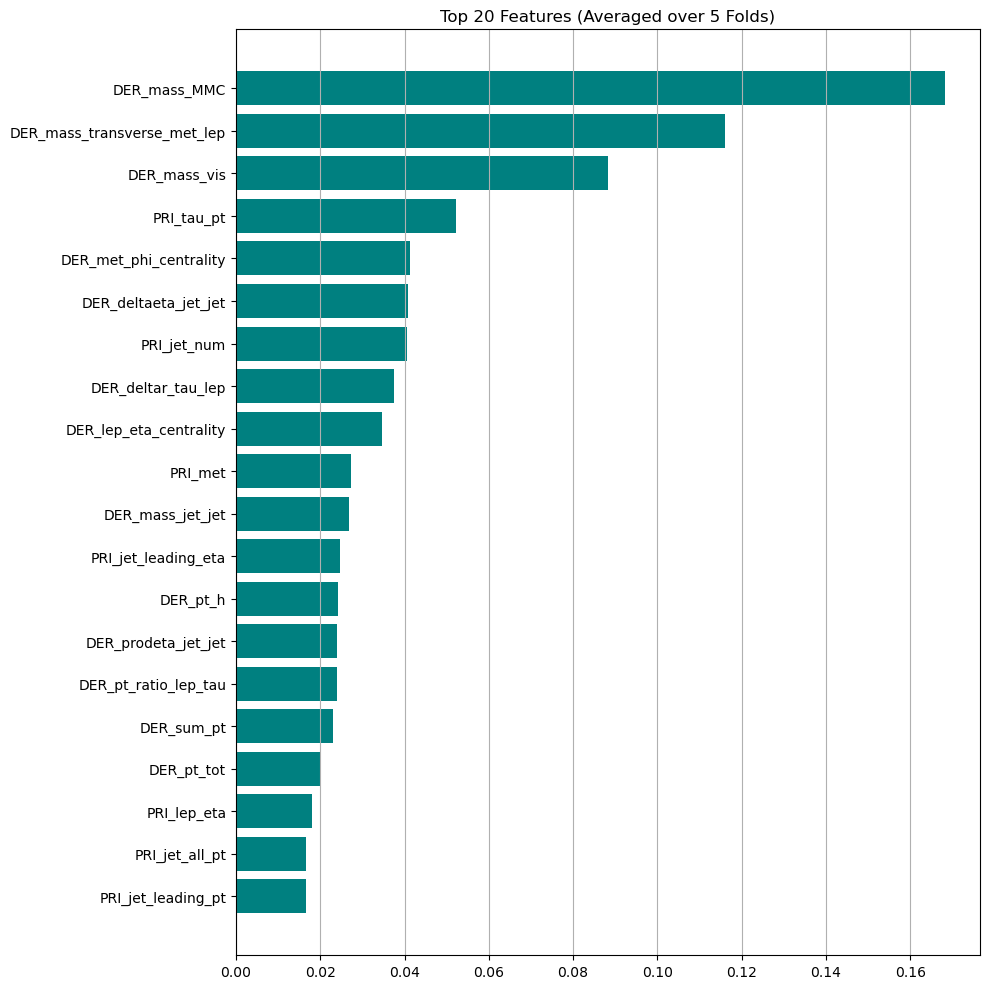

In [1]:
import os
import urllib.request
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import math

# ==========================================
# 1. データ準備
# ==========================================
def download(url, output):
    if not os.path.exists(output):
        print(f"Downloading {output}...")
        urllib.request.urlretrieve(url, output)
    else:
        print(f"{output} found. Loading...")

download("https://drive.google.com/uc?id=1JPOVfYXJNXeBgG_V0auiuK5W2CvP4_td", "training.csv")
df = pd.read_csv("training.csv")

y = (df["Label"] == "s").astype(int).values
weights = df["Weight"].values
X = df.drop(columns=["EventId", "Weight", "Label"]).values
col_names = df.drop(columns=["EventId", "Weight", "Label"]).columns.tolist()

# ==========================================
# 2. Stratified K-Fold (5分割アンサンブル)
# ==========================================
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

ams_scores = []
models = []
evals_results = []

# 全データに対する予測値（検証用）
oof_preds = np.zeros(X.shape[0])

print(f"\nStarting {n_splits}-Fold Cross Validation with Visualization...")

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n===== FOLD {fold + 1}/{n_splits} =====")
    
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    w_train, w_val = weights[train_idx], weights[val_idx]

    # --- XGBoost モデル定義 ---
    model = xgb.XGBClassifier(
        n_estimators=1000,       
        learning_rate=0.05,
        max_depth=9,
        min_child_weight=1,      
        gamma=0.1,               
        subsample=0.7,           
        colsample_bytree=0.7,    
        objective='binary:logistic',
        n_jobs=-1,
        random_state=42 + fold,
        missing=-999.0,          
        eval_metric=["auc", "logloss"],
        early_stopping_rounds=50
    )

    # 学習
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=100
    )
    
    # 結果の保存
    evals_results.append(model.evals_result())
    
    val_probs = model.predict_proba(X_val)[:, 1]
    oof_preds[val_idx] = val_probs
    models.append(model)

    # --- AMS計算 ---
    scale_factor = float(n_splits)
    thresholds = np.linspace(0.01, 0.99, 100)
    best_ams_fold = 0
    
    for th in thresholds:
        pred_label = (val_probs > th).astype(int)
        s = np.sum(w_val[(pred_label==1) & (y_val==1)]) * scale_factor
        b = np.sum(w_val[(pred_label==1) & (y_val==0)]) * scale_factor
        
        if b == 0: ams = 0
        else: ams = math.sqrt(2 * ((s + b + 10) * math.log(1 + s / (b + 10)) - s))
        
        if ams > best_ams_fold:
            best_ams_fold = ams
            
    print(f"Fold {fold+1} Best AMS: {best_ams_fold:.4f}")
    ams_scores.append(best_ams_fold)

# ==========================================
# 3. 総合評価
# ==========================================
print("\n" + "="*40)
print(" FINAL ENSEMBLE RESULTS")
print("="*40)
print(f"Average AMS: {np.mean(ams_scores):.4f} ± {np.std(ams_scores):.4f}")

print("\nCalculating Final Combined AMS...")

best_ams_final = 0
best_th_final = 0
thresholds = np.linspace(0.01, 0.99, 500)

for th in thresholds:
    pred_label = (oof_preds > th).astype(int)
    s = np.sum(weights[(pred_label==1) & (y==1)])
    b = np.sum(weights[(pred_label==1) & (y==0)])
    
    if b == 0: ams = 0
    else: ams = math.sqrt(2 * ((s + b + 10) * math.log(1 + s / (b + 10)) - s))
    
    if ams > best_ams_final:
        best_ams_final = ams
        best_th_final = th

print(f"FINAL SCORE : {best_ams_final:.5f}")
print(f"Optimal Threshold: {best_th_final:.3f}")

# ==========================================
# 4. 可視化 (Visualizations)
# ==========================================
print("\nGenerating Plots...")

plt.figure(figsize=(10, 6))
for i, result in enumerate(evals_results):
    epochs = len(result['validation_0']['logloss'])
    x_axis = range(0, epochs)
    # Trainは点線、Valは実線で描画
    plt.plot(x_axis, result['validation_0']['logloss'], label=f'Train Fold {i+1}', linestyle='--', alpha=0.5)
    plt.plot(x_axis, result['validation_1']['logloss'], label=f'Val Fold {i+1}', alpha=0.8, linewidth=1.5)

plt.ylabel('Log Loss')
plt.xlabel('Trees (Epochs)')
plt.title('XGBoost Loss Curves (5 Folds)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

bins = np.linspace(0.0, 1.0, 50)
plt.figure(figsize=(8, 6))
plt.hist(oof_preds[y==1], bins=bins, histtype='step', density=True, label='Signal (Combined)', color='red', linewidth=2)
plt.hist(oof_preds[y==0], bins=bins, histtype='step', density=True, label='Background (Combined)', color='blue', linewidth=2)
plt.axvline(best_th_final, color='black', linestyle='--', label=f'Optimal Cut ({best_th_final:.2f})')
plt.xlabel('Ensemble Prediction Score')
plt.ylabel('Normalized events')
plt.title('Signal vs Background Separation (Ensemble)')
plt.legend()
plt.grid(True)
plt.show()

# --- (3) Feature Importance (Averaged over 5 folds) ---
importances = np.zeros(len(col_names))
for model in models:
    model.get_booster().feature_names = col_names
    importances += model.feature_importances_

importances /= n_splits

indices = np.argsort(importances)[::-1][:20]
plt.figure(figsize=(10, 10))
plt.title("Top 20 Features (Averaged over 5 Folds)")
plt.barh(range(20), importances[indices], align="center", color="teal")
plt.yticks(range(20), np.array(col_names)[indices])
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.tight_layout()
plt.show()